# ResUNet Weld Seam Segmentation Training Pipeline
This notebook handles:
1. Downloading the `u-net_model` v4 dataset from Roboflow.
2. Defining the pure Deep Residual UNet (ResUNet) architecture.
3. Setting up data loaders with Image Augmentation (Albumentations).
4. Training the model with Mixed Precision, BCE+Dice Loss, and Cosine Annealing.
5. Running predictions on the test set and exporting `best_resunet_seam.pth`.

In [ ]:
!pip install -q roboflow albumentations
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from roboflow import Roboflow
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.0 MB/s eta 0:00:00
Using device: cuda


## 1. Download Dataset

In [ ]:
import zipfile, os

# Zip is already in session storage at /content/
zip_path = "/content/U-Net_model.v4i.png-mask-semantic.zip"

# Extract it
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/dataset")

# Show what we got
for root, dirs, files_list in os.walk("/content/dataset"):
    for f in files_list[:5]:
        print(os.path.join(root, f))
    break

DATA_YAML_PATH = "/content/dataset"
print("\nDataset ready at:", DATA_YAML_PATH)

/content/dataset/README.roboflow.txt
/content/dataset/README.dataset.txt

Dataset ready at: /content/dataset


In [5]:
import zipfile, os

zip_path = "/content/U-Net_model.v4i.png-mask-semantic.zip"

# Clean up any previous attempts
!rm -rf /content/dataset
os.makedirs("/content/dataset", exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/dataset")

# Print the folder structure deeply
print("Dataset Directory Structure:")
for root, dirs, files_list in os.walk("/content/dataset"):
    level = root.replace("/content/dataset", "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:  # Print a couple of files to verify
        subindent = " " * 4 * (level + 1)
        for f in files_list[:2]:
            print(f"{subindent}{f}")

DATA_YAML_PATH = "/content/dataset"


Dataset Directory Structure:
dataset/
    README.roboflow.txt
    README.dataset.txt
    train/
        12_jpg.rf.d76e19964deace7e928253e04407e333.jpg
        53_jpg.rf.2edb65eedb0e09e9820d04c2af88ba61_mask.png
    valid/
        N_32_jpg.rf.930edbe76382470c7bc3e71cfa9cb103_mask.png
        41_jpg.rf.d8e1bdafa108596afc14bc3289fcb65f.jpg
    test/
        211_jpg.rf.48d47f24d85c8a9f111a4baf69ea315c_mask.png
        107_jpg.rf.df9bb748e81be3e3c9fd48203429591d_mask.png


## 2. Deep Residual UNet (ResUNet) Architecture
Instead of plain convolutions, ResUNet uses residual blocks. This allows gradients to flow smoothly, preventing vanishing gradients, which is critical for thin paths like 1-pixel weld seams.

In [8]:
# ── Residual Block ───────────────────────────────────────────────────────────
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
        )
        self.skip = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.skip = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c),
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x) + self.skip(x))


# ── Encoder (Down-sampling) ──────────────────────────────────────────────────
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.res  = ResBlock(in_c, out_c)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip = self.res(x)
        x    = self.pool(skip)
        return skip, x


# ── Bridge ───────────────────────────────────────────────────────────────────
class Bridge(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.res = ResBlock(in_c, out_c)

    def forward(self, x):
        return self.res(x)


# ── Decoder (Up-sampling) ────────────────────────────────────────────────────
class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up  = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.res = ResBlock(out_c * 2, out_c)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.res(x)


# ── Full ResUNet ─────────────────────────────────────────────────────────────
class ResUNet(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super().__init__()
        self.e1     = EncoderBlock(in_c,   64)
        self.e2     = EncoderBlock(64,    128)
        self.e3     = EncoderBlock(128,   256)
        self.e4     = EncoderBlock(256,   512)
        self.bridge = Bridge(512, 1024)
        self.d4     = DecoderBlock(1024,  512)
        self.d3     = DecoderBlock(512,   256)
        self.d2     = DecoderBlock(256,   128)
        self.d1     = DecoderBlock(128,    64)
        self.head   = nn.Conv2d(64, out_c, kernel_size=1)

    def forward(self, x):
        s1, x = self.e1(x)
        s2, x = self.e2(x)
        s3, x = self.e3(x)
        s4, x = self.e4(x)
        x = self.bridge(x)
        x = self.d4(x, s4)
        x = self.d3(x, s3)
        x = self.d2(x, s2)
        x = self.d1(x, s1)
        return self.head(x)


# Sanity check — should print: ResUNet output shape: torch.Size([1, 1, 512, 512])
dummy      = torch.zeros(1, 3, 512, 512).to(device)
model_test = ResUNet().to(device)
out        = model_test(dummy)
print(f"ResUNet output shape: {out.shape}  (expected: [1, 1, 512, 512])")
total_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
print(f"Trainable parameters: {total_params:,}")
del model_test, dummy, out


ResUNet output shape: torch.Size([1, 1, 512, 512])  (expected: [1, 1, 512, 512])
Trainable parameters: 32,436,353


## 3. Dataset & Dataloaders

In [9]:
class WeldSeamDataset(Dataset):
    def __init__(self, folder_dir, transform=None):
        self.folder_dir = folder_dir
        # Find only the original images (ignoring the _mask.png files)
        self.images = [
            f for f in os.listdir(folder_dir)
            if f.endswith('.jpg') and not f.endswith('_mask.jpg') and not f.endswith('_mask.png')
        ]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.folder_dir, img_name)

        # The mask name is exactly the image name, but with '.jpg' replaced by '_mask.png'
        mask_name = img_name.replace('.jpg', '_mask.png')
        mask_path = os.path.join(self.folder_dir, mask_name)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Missing mask: Expected {mask_name} in {self.folder_dir}")

        # Load Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load Mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Binarize it: any pixel > 0 becomes 1
        mask = (mask > 0).astype(np.float32)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)

# Augmentations remain the same
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Use the exact paths from your output
DATA_YAML_PATH = "/content/dataset"

try:
    train_dataset = WeldSeamDataset(os.path.join(DATA_YAML_PATH, 'train'), transform=train_transform)
    val_dataset = WeldSeamDataset(os.path.join(DATA_YAML_PATH, 'valid'), transform=val_transform)
except Exception as e:
    print("Error loading datasets:", e)
    train_dataset, val_dataset = [], []

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) if len(train_dataset)>0 else []
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2) if len(val_dataset)>0 else []

print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}")


Train images: 226, Val images: 65


## 4. Loss Function
We use BCE + Dice Loss. Dice Loss specifically helps segment thin lines gracefully, since it scores intersection over union.

In [10]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets, smooth=1.0):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets)

        probs = torch.sigmoid(logits)
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)

        intersection = (probs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (probs_flat.sum() + targets_flat.sum() + smooth)

        return bce_loss + dice_loss

def compute_dice_coeff(logits, targets):
    probs = torch.sigmoid(logits) > 0.5
    intersection = (probs & (targets > 0.5)).sum().float()
    return (2. * intersection) / (probs.sum() + targets.sum() + 1e-6)

## 5. Training Loop
Trains the ResUNet model using Mixed Precision for speed and reduced memory.

In [11]:
model = ResUNet(in_c=3, out_c=1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = DiceBCELoss()
scaler = torch.cuda.amp.GradScaler()

num_epochs = 50
best_val_dice = 0.0

train_losses, val_losses, val_dices = [], [], []

if len(train_loader) > 0:
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                preds = model(imgs)
                loss = criterion(preds, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        scheduler.step()

        # Validation
        model.eval()
        val_loss, val_dice = 0, 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                with torch.cuda.amp.autocast():
                    preds = model(imgs)
                    loss = criterion(preds, masks)
                    val_loss += loss.item()
                    val_dice += compute_dice_coeff(preds, masks).item()

        val_losses.append(val_loss / len(val_loader))
        val_dice = val_dice / len(val_loader)
        val_dices.append(val_dice)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Dice: {val_dice:.4f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), "best_resunet_seam.pth")
            print("--> Saved new best model")

    print("Training Complete. Best Val Dice:", best_val_dice)

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 1/50 | Train Loss: 1.1516 | Val Loss: 1.0945 | Val Dice: 0.0042
--> Saved new best model
Epoch 2/50 | Train Loss: 1.0350 | Val Loss: 1.2029 | Val Dice: 0.2154
--> Saved new best model
Epoch 3/50 | Train Loss: 0.9678 | Val Loss: 1.1697 | Val Dice: 0.0832
Epoch 4/50 | Train Loss: 0.8983 | Val Loss: 0.8616 | Val Dice: 0.3486
--> Saved new best model
Epoch 5/50 | Train Loss: 0.7661 | Val Loss: 0.7463 | Val Dice: 0.4792
--> Saved new best model
Epoch 6/50 | Train Loss: 0.5925 | Val Loss: 0.7188 | Val Dice: 0.4472
Epoch 7/50 | Train Loss: 0.4905 | Val Loss: 0.5266 | Val Dice: 0.5452
--> Saved new best model
Epoch 8/50 | Train Loss: 0.4056 | Val Loss: 0.4365 | Val Dice: 0.6208
--> Saved new best model
Epoch 9/50 | Train Loss: 0.3381 | Val Loss: 0.4313 | Val Dice: 0.6115
Epoch 10/50 | Train Loss: 0.2911 | Val Loss: 0.3847 | Val Dice: 0.6401
--> Saved new best model
Epoch 11/50 | Train Loss: 0.3130 | Val Loss: 0.3912 | Val Dice: 0.6304
Epoch 12/50 | Train Loss: 0.2845 | Val Loss: 0.5195 |

## 6. Plotting Results and Exporting

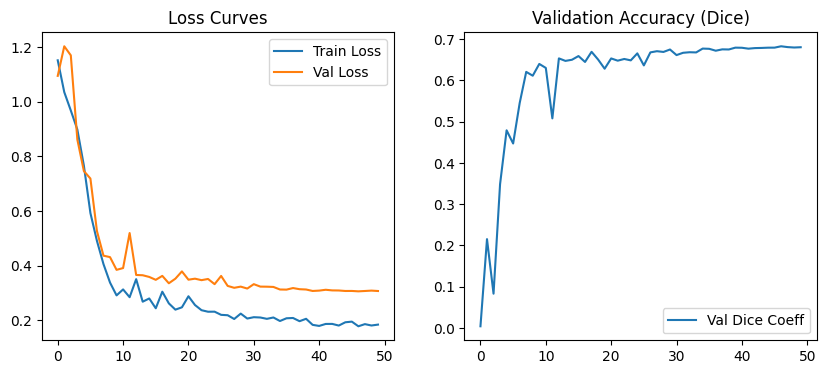

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
if len(train_losses) > 0:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(val_dices, label='Val Dice Coeff')
    plt.legend()
    plt.title('Validation Accuracy (Dice)')
    plt.show()

# To download the weights locally:
try:
    from google.colab import files
    files.download('best_resunet_seam.pth')
except:
    pass


--- Testing: 235_jpg.rf.74f2dc42a3736b88d7903ad8d7c2f650.jpg ---


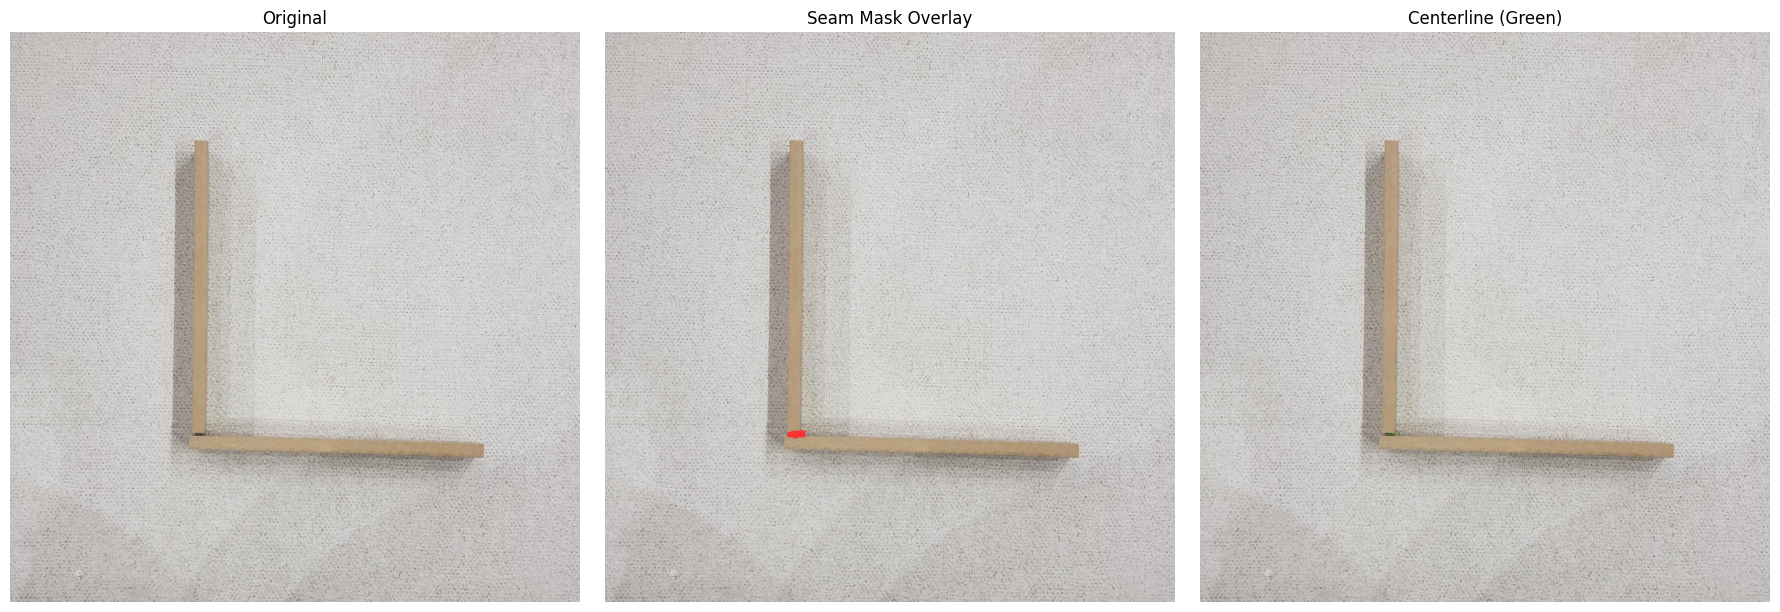

Seam pixels detected: 1732

--- Testing: 163_jpg.rf.6047474aedbc81b2e63d8f8177450d46.jpg ---


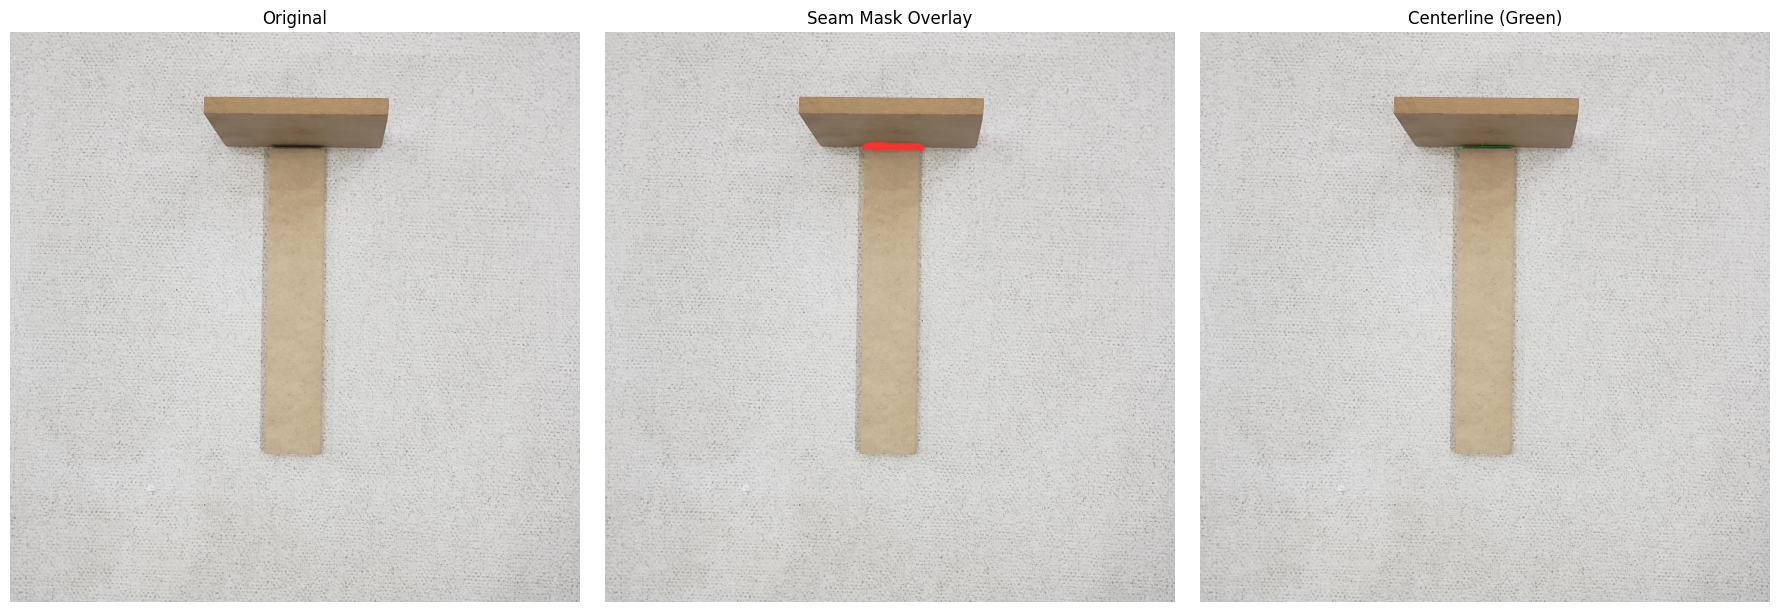

Seam pixels detected: 6142

--- Testing: 278_jpg.rf.e68d771bc647a90947606ec0cc0d89ea.jpg ---


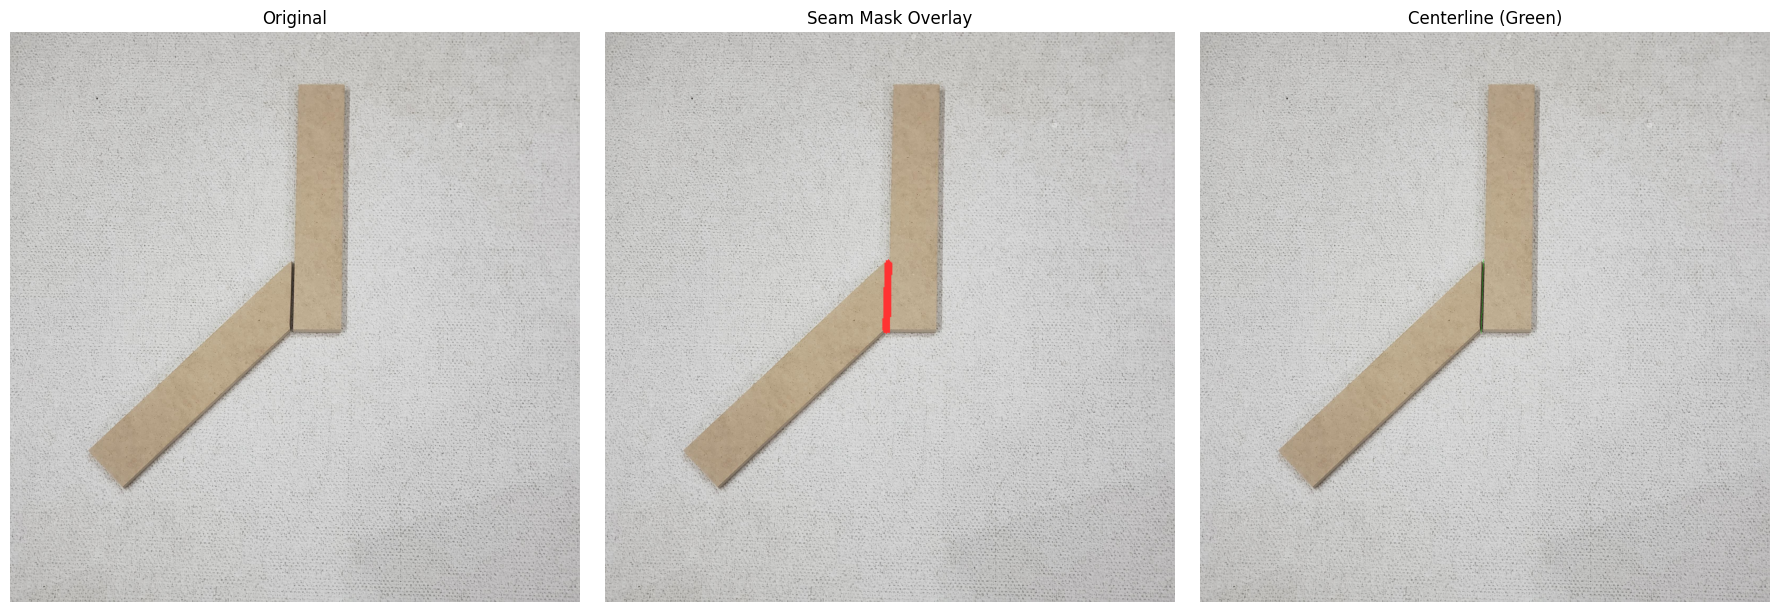

Seam pixels detected: 7872


In [13]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import os

def test_image_inline(image_path, model, device):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_h, original_w = img.shape[:2]

    # Preprocess
    img_resized = cv2.resize(img_rgb, (512, 512))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_norm = (img_resized / 255.0 - mean) / std
    inp = torch.tensor(img_norm).float().permute(2, 0, 1).unsqueeze(0).to(device)

    # Run inference
    model.eval()
    with torch.no_grad():
        pred = torch.sigmoid(model(inp))
        mask = (pred > 0.5).squeeze().cpu().numpy()

    mask = cv2.resize(mask.astype(np.uint8), (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    # Overlay + skeleton
    overlay = img_rgb.copy()
    overlay[mask == 1] = [255, 50, 50]
    skeleton = skeletonize(mask)
    skel_vis = img_rgb.copy()
    skel_vis[skeleton] = [0, 255, 0]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(img_rgb);        axes[0].set_title("Original");           axes[0].axis("off")
    axes[1].imshow(overlay);        axes[1].set_title("Seam Mask Overlay");  axes[1].axis("off")
    axes[2].imshow(skel_vis);       axes[2].set_title("Centerline (Green)"); axes[2].axis("off")
    plt.tight_layout()
    plt.savefig(f"/content/result_{os.path.basename(image_path)}.png", dpi=150)
    plt.show()
    print(f"Seam pixels detected: {mask.sum()}")

# Load the best saved model
model = ResUNet().to(device)
model.load_state_dict(torch.load("best_resunet_seam.pth", map_location=device))

# Test on a few images from the test set
test_folder = "/content/dataset/test"
test_images = [f for f in os.listdir(test_folder) if f.endswith('.jpg')][:3]

for img_name in test_images:
    print(f"\n--- Testing: {img_name} ---")
    test_image_inline(os.path.join(test_folder, img_name), model, device)
